# TCLAB

## Import

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
import package_LAB
from package_LAB import *

## Load data

In [8]:
nameFile = 'Open_loop_experiment_on_MV_2022-04-27-00h39.txt' #notre sample at home

if 'MV' in nameFile:
    ExpVariable = 'MV'
else:    
    ExpVariable = 'DV'
    
print(ExpVariable)    
    
titleName = nameFile.split('.')[0]    
data = pd.read_csv('DATA/' + nameFile)
t = data['t'].values - data['t'].values[0]
MV = data['MV'].values
PV = data['PV'].values
DV = data['DV'].values

MV


## Plot loaded data

(45.0, 55.0)

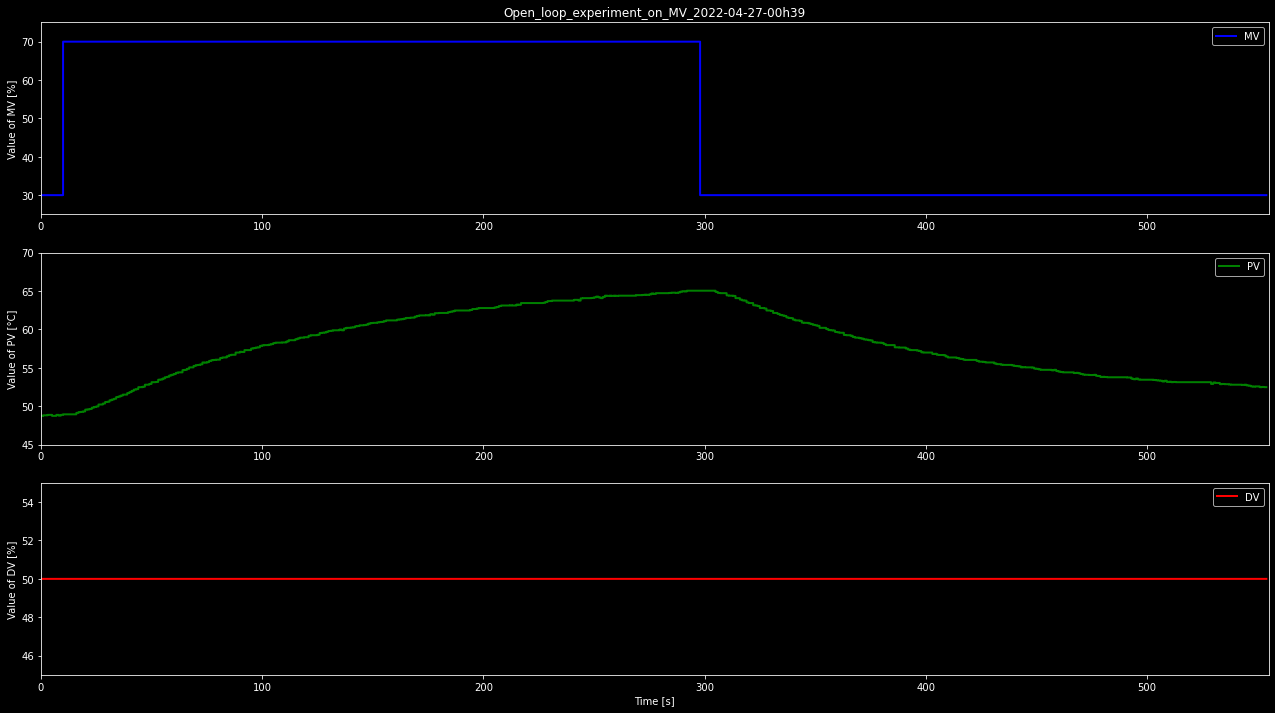

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title(titleName)
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')

l1.set_data(t,MV)
l2.set_data(t,PV)
l3.set_data(t,DV)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)
ax3.set_xlim(0, t[-1]+1)

ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)

## Clean data

In [10]:
if ExpVariable == 'MV':
    tstep = np.argwhere(np.diff(MV) != 0)
    tstep = tstep[0][0]
    tm = t[tstep:]
    tm = tm - tm[0]    
    MVstep = MV[tstep + 1] - MV[tstep]
    MVm = MV[tstep:]
    PVm = PV[tstep:]
    PVm = (PVm - PVm[0])/MVstep
    MVm = (MVm - MVm[0])/MVstep    
else:    
    tstep = np.argwhere(np.diff(DV) != 0)
    tstep = tstep[0][0]
    tm = t[tstep:]
    tm = tm - tm[0]
    DVstep = DV[tstep + 1] - DV[tstep]    
    DVm = DV[tstep:]
    PVm = PV[tstep:]
    PVm = (PVm - PVm[0])/DVstep
    DVm = (DVm - DVm[0])/DVstep

## Plot cleaned data

(0.0, 555.0)

<Figure size 1584x1584 with 0 Axes>

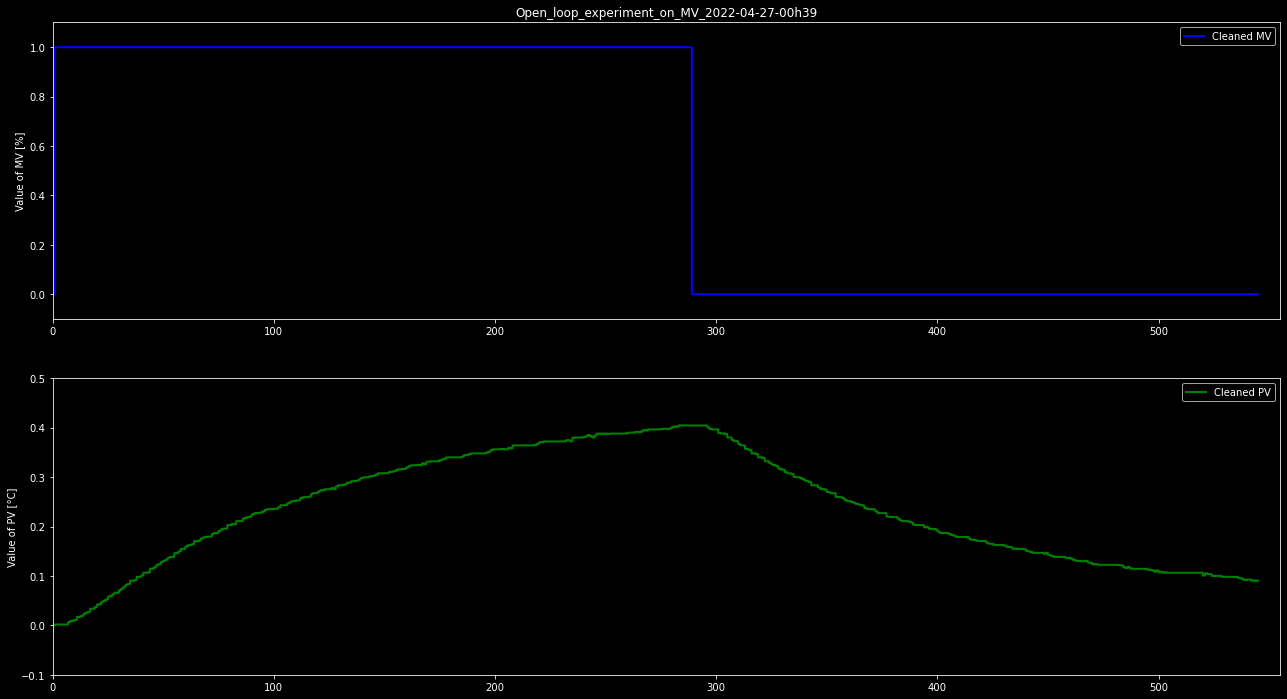

In [11]:
plt.figure(figsize = (22,22))

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(12)
fig.set_figwidth(22)

if ExpVariable == 'MV':
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned MV',where='post')
    ax1.set_ylabel('Value of MV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,MVm)
    ax1.set_ylim(myRound(np.min(MVm),1)-0.1, myRound(np.max(MVm),1)+0.1)    
else:
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned DV',where='post')
    ax1.set_ylabel('Value of DV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,DVm)
    ax1.set_ylim(myRound(np.min(DVm),1)-0.1, myRound(np.max(DVm),1)+0.1)     

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='Cleaned PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')
l2.set_data(tm,PVm)
ax2.set_ylim(myRound(np.min(PVm),0.1)-0.1, myRound(np.max(PVm),0.1)+0.1)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)

# SOPDT identification

#### Optimisation parameters

In [12]:
Ts = 1.0

maxIter = 10

p0 = np.zeros(4)
p0[0] = 0.65 # K
p0[1] = 100.0 # T1
p0[2] = 20.0 # T2
p0[3] = 10.0 # theta

bnds = ((None, None), (0, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost = SOPDT_cost(p0,MVm,PVm,Ts)
else:
    cost = SOPDT_cost(p0,DVm,PVm,Ts)
    
print('Initial cost: ' + str(cost))

Initial cost: 8.764543641567673


#### Optimisation

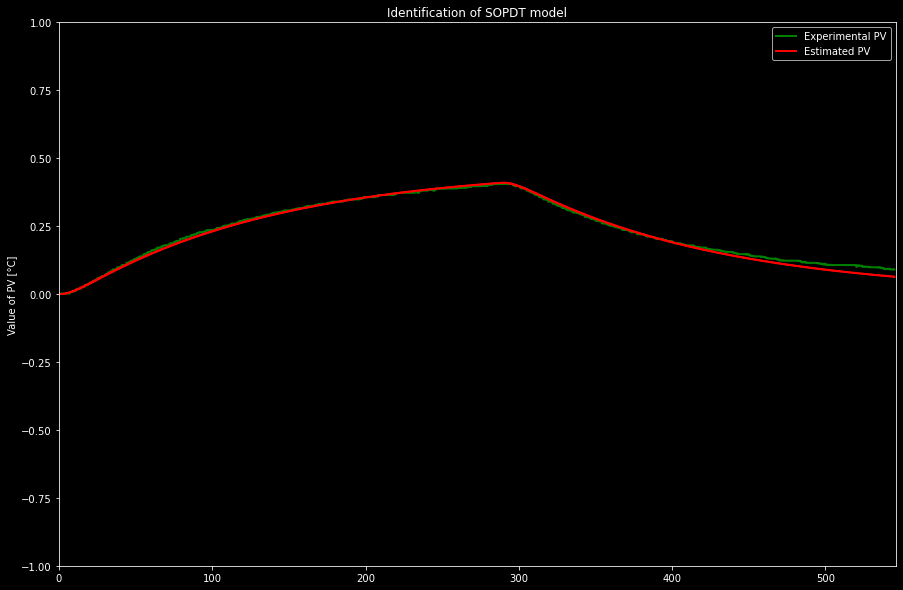

Final SSE Objective: 0.05747245175765793
K: 0.46575892823243076
T1: 132.04151002516983
T2: 7.647730018039972
theta: 0.0004910330468864688


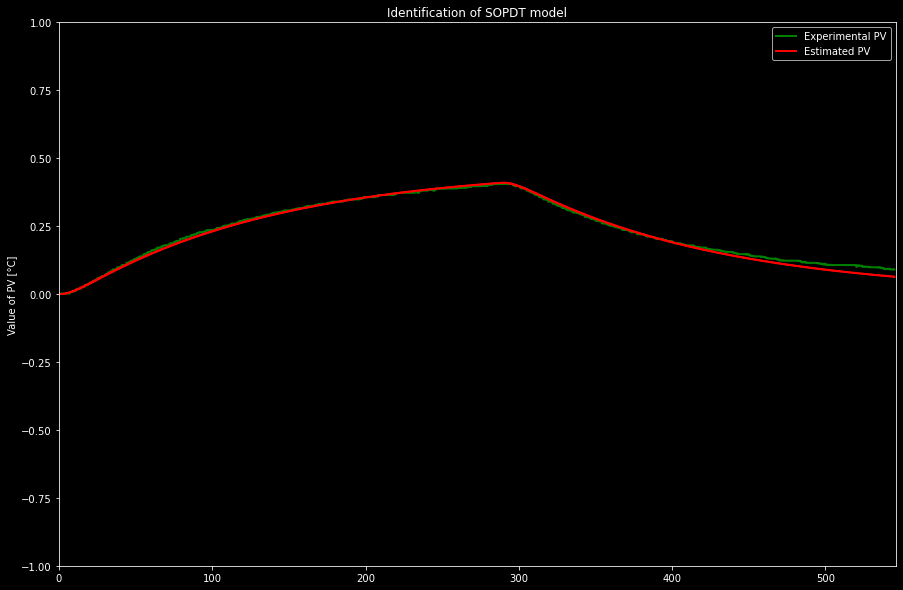

In [13]:
# optimize K, T1, T2, theta

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
l1, = ax1.step([0,1],[0,1],'g-',linewidth=2,label='Experimental PV',where='post')
l2, = ax1.step([0,1],[0,1],'r-',linewidth=2,label='Estimated PV',where='post')
ax1.set_ylabel('Value of PV [°C]')
ax1.set_title('Identification of SOPDT model')
ax1.legend(loc='best')

if ExpVariable == 'MV':
    solution = minimize(SOPDT_cost,p0,args=(MVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})
    p = solution.x
    print('Final SSE Objective: ' + str(SOPDT_cost(p,MVm,PVm,Ts)))
else:
    solution = minimize(SOPDT_cost,p0,args=(DVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
    p = solution.x
    print('Final SSE Objective: ' + str(SOPDT_cost(p,DVm,PVm,Ts)))

K = p[0]
T1 = np.max([0,p[1]])
T2 = np.max([0,p[2]])
theta  = np.max([0,p[3]])

print('K: ' + str(K))
print('T1: ' + str(T1))
print('T2: ' + str(T2))
print('theta: ' + str(theta))  

#### Plot experimental and simulated data

(0.0, 550.0)

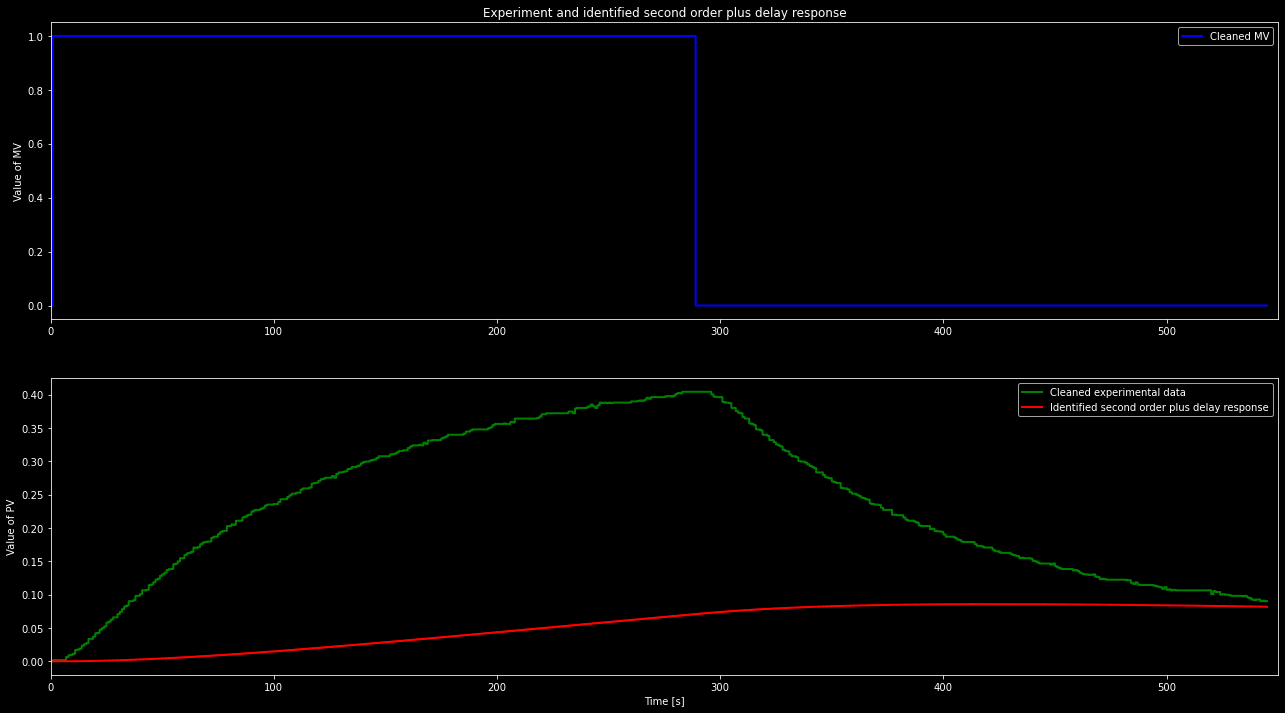

In [27]:
if ExpVariable == 'MV':
    PV_SOPDT_model = SOPDT(MVm,K,T1,T2,theta,Ts)
else:
    PV_SOPDT_model = SOPDT(DVm,K,T1,T2,theta,Ts)    

plt.figure(figsize = (22,12))

plt.subplot(2,1,1)
if ExpVariable == 'MV':
    plt.step(tm,MVm,'b-',linewidth=2,label='Cleaned MV',where='post')
    plt.ylabel('Value of MV')
else:
    plt.step(tm,DVm,'b-',linewidth=2,label='Cleaned DV',where='post')
    plt.ylabel('Value of DV') 
    
plt.title('Experiment and identified second order plus delay response')
plt.legend(loc='best')
plt.xlim([0, t[-1]])

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',linewidth=2,label='Cleaned experimental data',where='post')
plt.step(tm,PV_SOPDT_model,'r-',linewidth=2,label='Identified second order plus delay response',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, t[-1]])

# FOPDT identification

#### Optimisation parameters

In [15]:
Ts = 1.0

maxIter = 500

p0 = np.zeros(3)
p0[0] = 0.5 # K
p0[1] = 100.0 # T
p0[2] = 10.0 # theta

bnds = ((None, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost = FOPDT_cost(p0,MVm,PVm,Ts)
else:
    cost = FOPDT_cost(p0,DVm,PVm,Ts)
    
print('Initial cost: ' + str(cost))

Initial cost: 1.3599035051490658


#### Optimisation

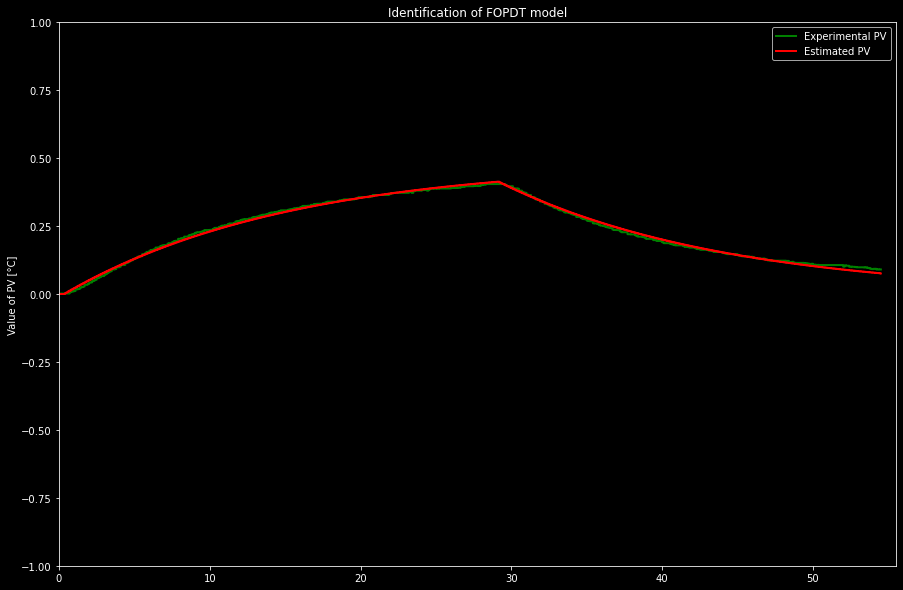

Final SSE Objective: 0.027300189613911036
K: 0.48398989727689795
T: 14.927471000887966
theta: 0.23565498038903543


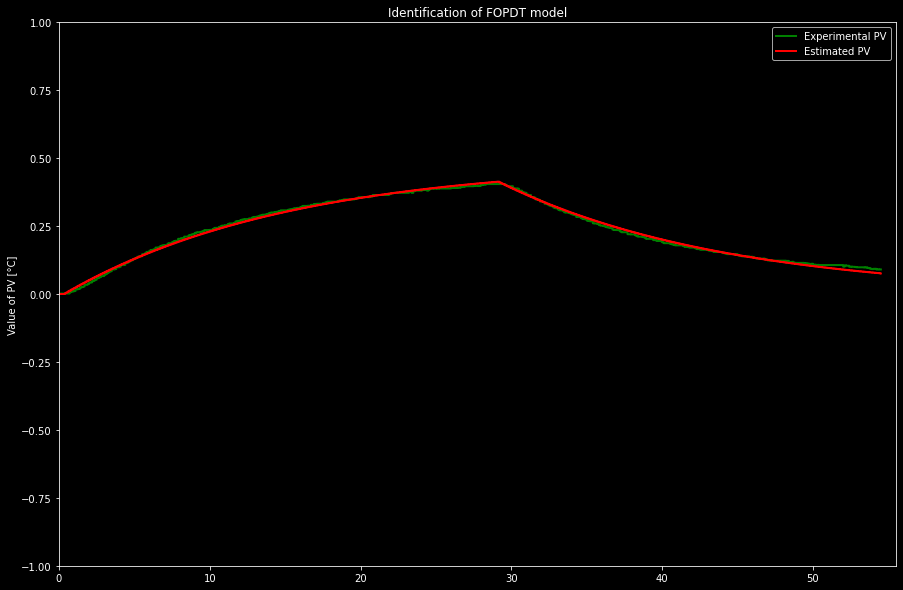

In [23]:
# optimize K, T, theta

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
l1, = ax1.step([0,1],[0,1],'g-',linewidth=2,label='Experimental PV',where='post')
l2, = ax1.step([0,1],[0,1],'r-',linewidth=2,label='Estimated PV',where='post')
ax1.set_ylabel('Value of PV [°C]')
ax1.set_title('Identification of FOPDT model')
ax1.legend(loc='best')

if ExpVariable == 'MV':
    solution = minimize(FOPDT_cost,p0,args=(MVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
    p = solution.x
    print('Final SSE Objective: ' + str(FOPDT_cost(p,MVm,PVm,Ts)))
else:
    solution = minimize(FOPDT_cost,p0,args=(DVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
    p = solution.x
    print('Final SSE Objective: ' + str(FOPDT_cost(p,DVm,PVm,Ts)))

K = p[0]
T = np.max([0,p[1]])
theta  = np.max([0,p[2]])

print('K: ' + str(K))
print('T: ' + str(T))
print('theta: ' + str(theta))  

#### Plot experimental and simulated data

(0.0, 550.0)

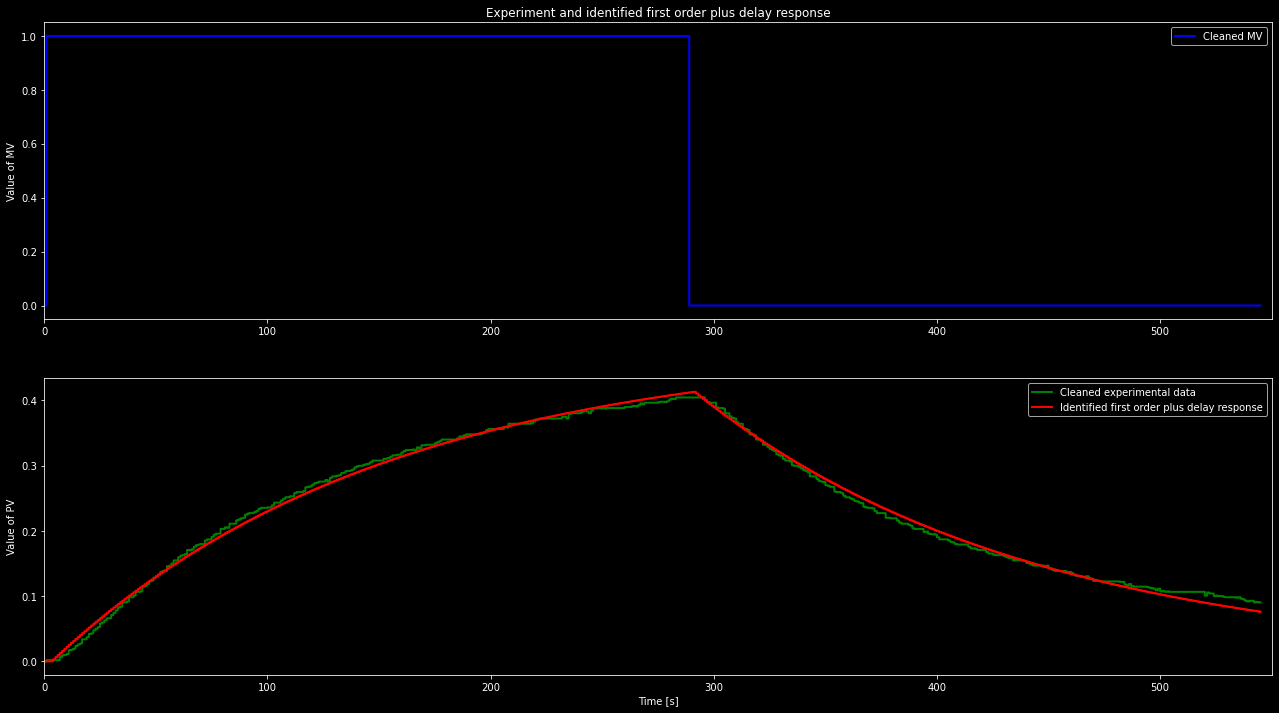

In [26]:
if ExpVariable == 'MV':
    PV_FOPDT_model = FOPDT(MVm,K,T,theta,Ts)
else:
    PV_FOPDT_model = FOPDT(DVm,K,T,theta,Ts)    

plt.figure(figsize = (22,12))

plt.subplot(2,1,1)
if ExpVariable == 'MV':
    plt.step(tm,MVm,'b-',linewidth=2,label='Cleaned MV',where='post')
    plt.ylabel('Value of MV')
else:
    plt.step(tm,DVm,'b-',linewidth=2,label='Cleaned DV',where='post')
    plt.ylabel('Value of DV') 
    
plt.title('Experiment and identified first order plus delay response')
plt.legend(loc='best')
plt.xlim([0, t[-1]])

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',linewidth=2,label='Cleaned experimental data',where='post')
plt.step(tm,PV_FOPDT_model,'r-',linewidth=2,label='Identified first order plus delay response',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, t[-1]])

# GRAPH METHODS 

## Simple Broida 

In [18]:
TSim = 550
Ts = 0.1
N = int(TSim/Ts) + 1

# Path for MV
MVPath = {0: 1, 295 :0}

t = []
MV = []

# Parameters
Kp = 0.4
T = 143.06
theta = 6.33

# MV is created from MVPath
for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(MVPath,t,MV)
    
PV_simple_broida = FOPDT(MV,Kp,T,theta,Ts)

## Complex Broida

In [19]:
TSim = 550
Ts = 0.1
N = int(TSim/Ts) + 1

# Path for MV
MVPath = {0: 1, 295 :0}

t = []
MV = []
# Parameters
Kp = 0.4
T = 97.46
theta = 13.69

# MV is created from MVPath
for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(MVPath,t,MV)
    
PV_broida = FOPDT(MV,Kp,T,theta,Ts)

## Van den Grinten

#### Plot

(0.0, 550.0)

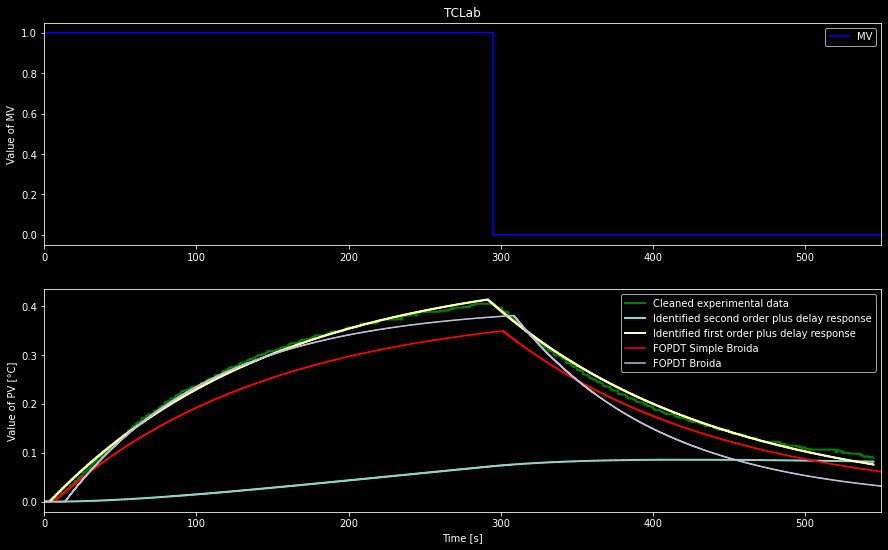

In [36]:
plt.figure(figsize = (15,9))

plt.subplot(2,1,1)
plt.step(t,MV,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('TCLab')
plt.legend(loc='best')
plt.xlim([0, TSim])



plt.subplot(2,1,2)

plt.step(tm,PVm, 'g-', linewidth=2,label='Cleaned experimental data',where='post')
plt.step(tm,PV_SOPDT_model, linewidth=2,label='Identified second order plus delay response',where='post')
plt.step(tm,PV_FOPDT_model, linewidth=2,label='Identified first order plus delay response',where='post')
plt.step(t,PV_simple_broida,'r-',label='FOPDT Simple Broida',where='post')
plt.step(t,PV_broida, label='FOPDT Broida',where='post')

plt.ylabel('Value of PV [°C]')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim]) 



# BODE DIAGRAMS

In [21]:
help(Bode)

Help on function Bode in module package_LAB:

Bode(P, omega, Show=True)
    :P: Process as defined by the class "Process".
        Use the following command to define the default process which is simply a unit gain process:
            P = Process({})
        
        A delay, two lead time constants and 2 lag constants can be added.
        
        Use the following commands for a SOPDT process:
            P.parameters['Kp'] = 1.1
            P.parameters['Tlag1'] = 10.0
            P.parameters['Tlag2'] = 2.0
            P.parameters['theta'] = 2.0
        
        Use the following commands for a unit gain Lead-lag process:
            P.parameters['Tlag1'] = 10.0        
            P.parameters['Tlead1'] = 15.0     
    
    :C: PID controller as defined by the class "Controller".
        Use the following command to define the default PID :
            P = Process({})
        
    :omega: frequency vector (rad/s); generated by a command of the type "omega = np.logspace(-2, 2, 1

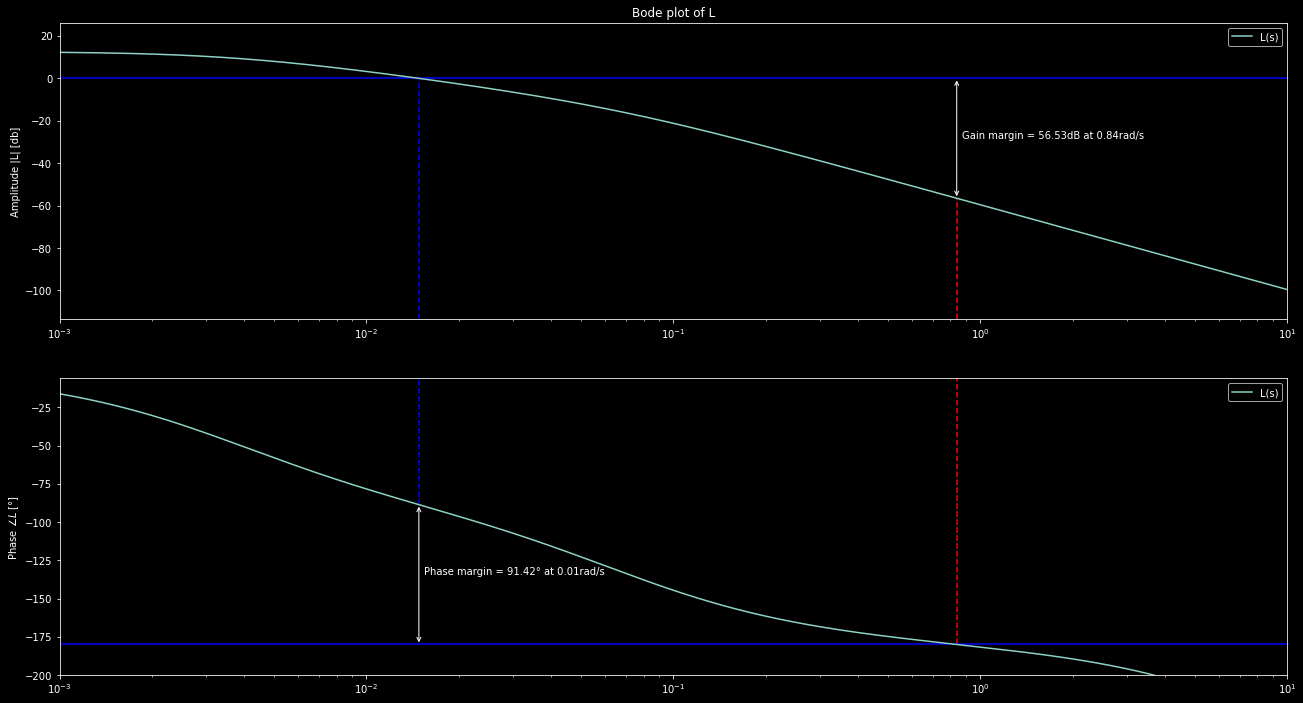

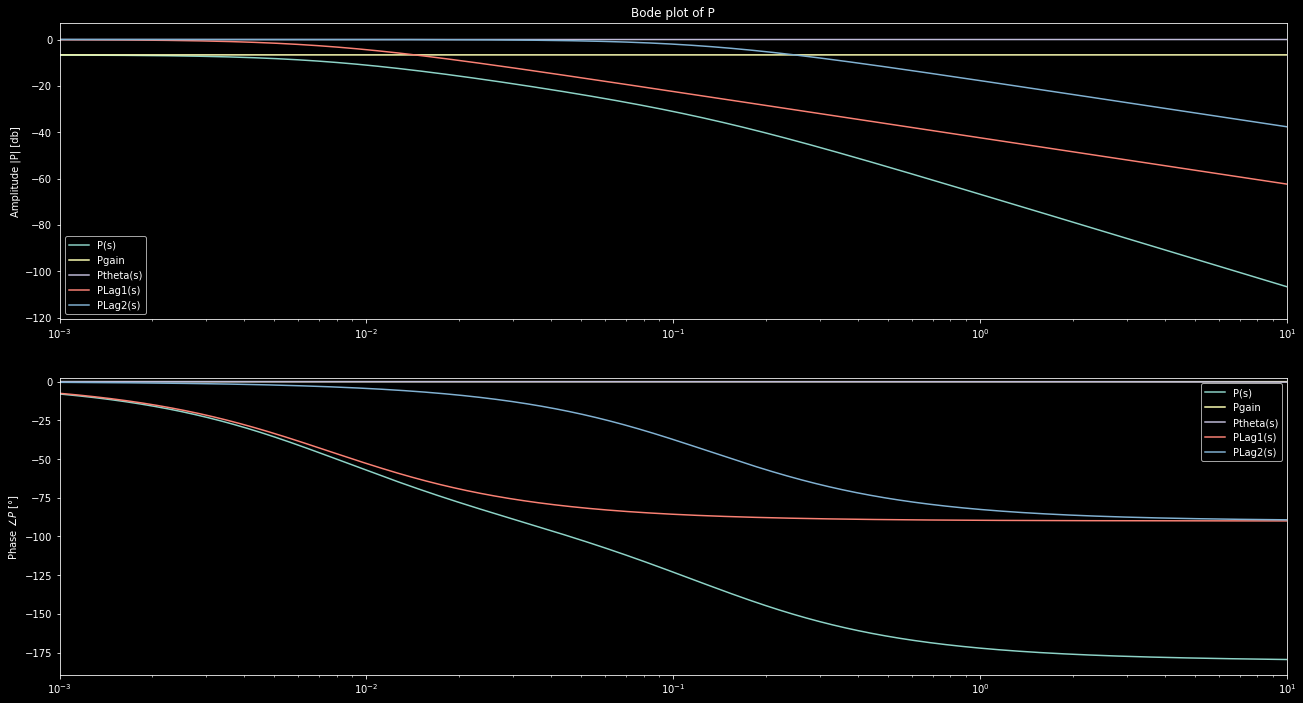

In [12]:
P = Process({})

P.parameters['Kp'] = 0.46575892823243076
P.parameters['Tlag1'] = 132.04151002516983
P.parameters['Tlag2'] = 7.647730018039972
P.parameters['theta'] = 0.0004910330468864688

#omega = np.logspace(-2, 2, 10000)
#Bode(P, omega )

C = Controller({})
C.parameters['Kc'] = 3.785622825343554
C.parameters['Ti'] =  139.6892400432098
C.parameters['Td'] =  7.229030808202924
C.parameters['alpha']= 0.1


omega = np.logspace(-3, 1, 10000)

StabilityMargins(P,C,omega)
Bode(P, omega )

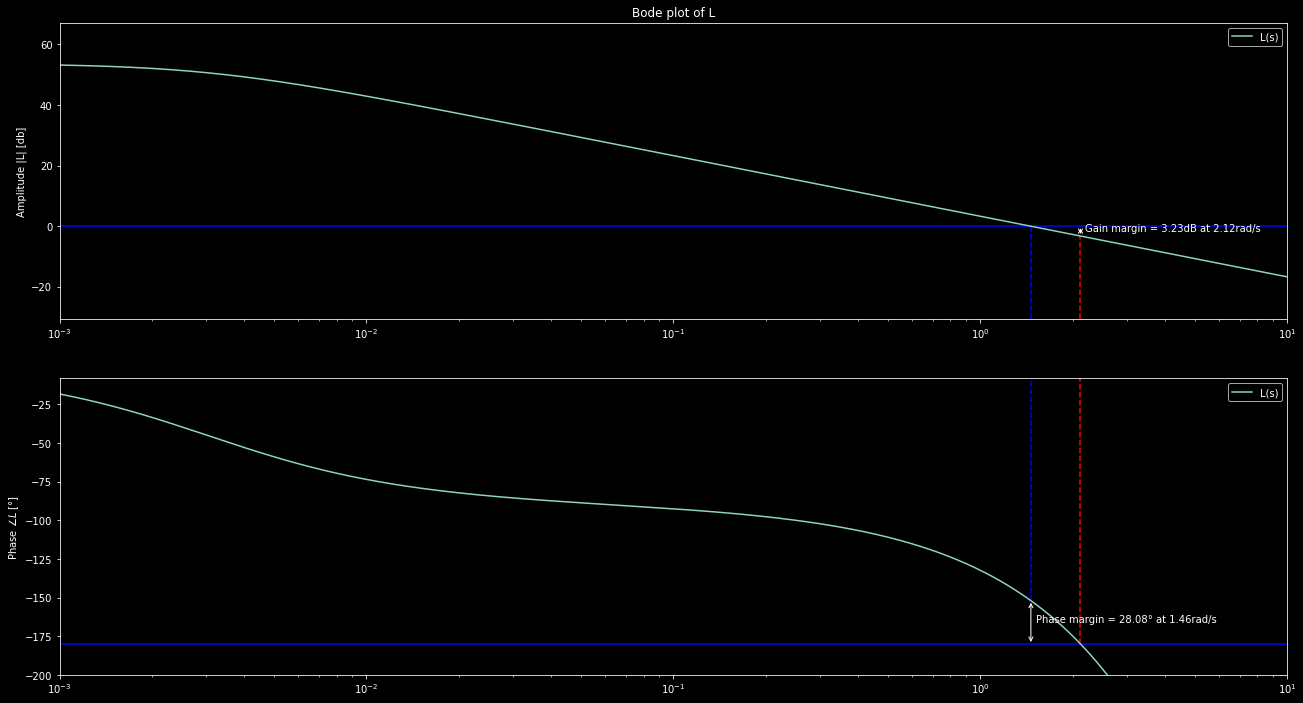

In [3]:
P = Process({}) 
P.parameters['Kp'] = 0.39
P.parameters['Tlag1'] = 165.56685644081972
P.parameters['Tlag2'] = 3.645364787323084e-05
P.parameters['theta'] = 0.6102455489040157


C = Controller({}) 
C.parameters['Kc'] = 480.2057733520492
C.parameters['Ti'] = 162.8843701247304
C.parameters['Td'] = 3.64348553216751e-05
C.parameters['alpha'] = 0.13

omega = np.logspace(-3, 1, 10000)

StabilityMargins(P,C,omega)